In [1]:
import pandas as pd
import os
import pickle
import joblib
import logging
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, accuracy
from surprise.model_selection import train_test_split

In [2]:
data_path = "data/processed/reviews.csv"
output_dir = "models/recommendation"
sentiment_model_dir = "models/sentiment-analysis"
log_dir = "log"
algorithm = "SVD"
custom_params = None
teencode_path = "resources/teencode.csv"
stopwords_path = "resources/stopwords.txt"
phrases_path = "resources/phrase_mapping.csv"

mf_results = {}

In [3]:
# Logging setup
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, "train_recommendation_model.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler(log_file, encoding="utf-8"), logging.StreamHandler()],
)

In [4]:
def load_data(
    file_path: str,
    sentiment_model=None,
    text_processor=None,
    filter_mismatch: bool = False,
    invalid_output_path: str = 'reviews_invalid.csv',
    use_deep_learning: bool = False,
    tokenizer=None,
):
    """
    Load rating data and optionally filter out mismatched sentiment-rating rows.
    Keeps reviews without comments and only filters ones with comment mismatches.

    Parameters:
        file_path (str): Path to ratings CSV file.
        sentiment_model: Pre-trained sentiment classification model (ML model or PhoBERT).
        text_processor: TextProcessor instance (only used for ML models).
        filter_mismatch (bool): Whether to remove mismatched sentiment-rating pairs.
        invalid_output_path (str): File path to store removed rows if any.
        use_deep_learning (bool): If True, use PhoBERT model; if False, use traditional ML model.
        tokenizer: Tokenizer for PhoBERT model (required when use_deep_learning=True).

    Returns:
        Dataset: surprise.Dataset object
    """
    from surprise import Dataset, Reader
    import torch
    
    logging.info(f"Loading data from {file_path}")
    df = pd.read_csv(file_path)

    total_before = len(df)

    if filter_mismatch:
        if sentiment_model is None:
            raise ValueError("Sentiment model is required for filtering.")
        
        if use_deep_learning and tokenizer is None:
            raise ValueError("Tokenizer is required when using deep learning model.")
        
        if not use_deep_learning and text_processor is None:
            raise ValueError("Text processor is required when using traditional ML model.")

        logging.info(f"Filtering mismatched sentiment and rating using {'deep learning (PhoBERT)' if use_deep_learning else 'traditional ML'}...")

        # Identify rows with comment to process
        comment_mask = df["comment"].notna() & df["comment"].str.strip().ne("")

        df_comment = df[comment_mask].copy()
        
        if use_deep_learning:
            # Use PhoBERT for sentiment prediction
            df_comment["predicted_sentiment"] = df_comment["comment"].apply(
                lambda text: predict_sentiment_phobert(text, sentiment_model, tokenizer)
            )
        else:
            # Use traditional ML approach
            df_comment["processed"] = df_comment["comment"].astype(str).apply(text_processor.preprocess)
            df_comment["predicted_sentiment"] = sentiment_model.predict(df_comment["processed"])

        # Valid if rating matches predicted sentiment
        df_comment["is_valid"] = ~(
            ((df_comment["rating"] >= 4) & (df_comment["predicted_sentiment"] == "neg")) |
            ((df_comment["rating"] <= 2) & (df_comment["predicted_sentiment"] == "pos"))
        )

        # Combine: keep valid comments + all no-comment rows
        mismatched = df_comment[~df_comment["is_valid"]]
        valid_comments = df_comment[df_comment["is_valid"]]
        df_nocomment = df[~comment_mask]
        df_final = pd.concat([valid_comments, df_nocomment], ignore_index=True)

        # Logging
        logging.info(f"Total reviews before filtering: {total_before}")
        logging.info(f"Reviews with comment: {len(df_comment)}")
        logging.info(f"Reviews removed due to mismatch: {len(mismatched)}")
        logging.info(f"Remaining reviews after filtering: {len(df_final)}")

        # Save mismatched reviews
        parent_dir = os.path.dirname(invalid_output_path)
        if parent_dir:
            os.makedirs(parent_dir, exist_ok=True)
        mismatched.to_csv(invalid_output_path, index=False, encoding="utf-8")
        logging.info(f"Mismatched reviews saved to {invalid_output_path}")

        df = df_final

    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[["userId", "productId", "rating"]], reader)
    return data


def predict_sentiment_phobert(text: str, model, tokenizer) -> str:
    """
    Predict sentiment using PhoBERT model.
    
    Parameters:
        text (str): Input text to analyze
        model: PhoBERT model for sentiment classification
        tokenizer: PhoBERT tokenizer
        
    Returns:
        str: Predicted sentiment ('pos' or 'neg')
    """
    import torch
    
    # Tokenize input text
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        truncation=True, 
        padding=True, 
        max_length=256
    )
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
    
    # Convert to sentiment label (assuming 0=negative, 1=positive)
    return "pos" if predicted_class == 1 else "neg"


def train_model(data, algorithm="SVD", params=None):
    logging.info(f"Training model using algorithm: {algorithm}")
    trainset, testset = train_test_split(data, test_size=0.2)


    if algorithm == "SVD":
        default_params = {
            "n_factors": 20,
            "n_epochs": 50,
            "lr_all": 0.005,
            "reg_all": 0.01,
        }
        model = SVD(**(params or default_params))
    elif algorithm == "NMF":
        default_params = {"n_factors": 50, "n_epochs": 50}
        model = NMF(**(params or default_params))
    elif algorithm == "KNNBasic":
        default_params = {
            "k": 40,
            "sim_options": {"name": "cosine", "user_based": False},
        }
        model = KNNBasic(**(params or default_params))
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

    model.fit(trainset)

    predictions = model.test(testset)

    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)


    logging.info(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    return model, rmse, mae


def save_model(model, output_dir="model.pkl"):
    with open(output_dir, "wb") as f:
        pickle.dump(model, f)
    logging.info(f"Model saved to {output_dir}")


def load_model(model_path="model.pkl"):
    try:
        with open(model_path, "rb") as f:
            model = pickle.load(f)
        logging.info(f"Model loaded from {model_path}")


        return model
    except Exception as e:
        logging.error(f"Failed to load model: {e}")
        return None


def load_sentiment_model(model_path):
    """Load a trained sentiment analysis model from file."""
    try:
        model = joblib.load(model_path)
        logging.info(f"Model loaded from {model_path}")
        return model
    except Exception as e:
        logging.error(f"Failed to load model: {e}")
        exit(1)


def get_user_recommendations(model, df, userId, top_k=10, exclude_purchased=True):
    all_products = df["productId"].unique()
    user_products = set(df[df["userId"] == userId]["productId"].values)

    predictions = []

    for productId in all_products:
        if exclude_purchased and productId in user_products:
            continue
        pred = model.predict(userId, productId)
        predictions.append((productId, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_recs = [prod_id for prod_id, _ in predictions[:top_k]]
    return top_recs

In [5]:
logging.info("Start training pipeline")
data = load_data(data_path)
model, rmse, mae = train_model(data, algorithm, custom_params)
model_path = f"{output_dir}/mf_{algorithm}.pkl"
save_model(model, model_path)

print("✅ Training complete")
print("RMSE:", rmse)
print("MAE:", mae)
print("Model saved to:", model_path)
mf_results["original"] = (rmse, mae)

2025-06-27 08:27:05,970 - INFO - Start training pipeline
2025-06-27 08:27:12,545 - INFO - Loading data from data/processed/reviews.csv
2025-06-27 08:27:13,856 - INFO - Training model using algorithm: SVD
2025-06-27 08:27:22,853 - INFO - RMSE: 0.5591, MAE: 0.2956
2025-06-27 08:27:23,266 - INFO - Model saved to models/recommendation/mf_SVD.pkl


✅ Training complete
RMSE: 0.5591117970923313
MAE: 0.2956284681194409
Model saved to: models/recommendation/mf_SVD.pkl


In [6]:
from preprocessing.text_processor import TextProcessor

# Initialize text processor
processor = TextProcessor(
    teencode_path=teencode_path,
    stopword_path=stopwords_path,
    phrase_mapping_path=phrases_path,
)

In [7]:
import logging

sentiment_models = ["svm", "logistic", "naive_bayes", "random_forest", "knn"]

for model_name in sentiment_models:
    print(f"\n🔄 Running MF pipeline with sentiment model: {model_name.upper()}")
    logging.info(f"Start training pipeline with sentiment model: {model_name}")

    sentiment_model_path = f"{sentiment_model_dir}/{model_name}.pkl"
    sentiment_model = load_sentiment_model(sentiment_model_path)

    data = load_data(
        data_path,
        sentiment_model,
        processor,
        filter_mismatch=True,
        invalid_output_path=f"{log_dir}\invalid_reviews_{model_name}.log",
    )

    model, rmse, mae = train_model(data, algorithm, custom_params)
    save_model(model, f"{output_dir}\mf_{model_name}.pkl")

    # Ghi log và hiển thị kết quả
    print(f"✅ MF Training complete with sentiment model: {model_name.upper()}")
    print("📉 RMSE:", rmse)
    print("📈 MAE:", mae)

    mf_results[model_name] = (rmse, mae)

2025-06-27 08:27:26,982 - INFO - Start training pipeline with sentiment model: svm



🔄 Running MF pipeline with sentiment model: SVM


2025-06-27 08:27:27,846 - INFO - Model loaded from models/sentiment-analysis/svm.pkl
2025-06-27 08:27:27,846 - INFO - Loading data from data/processed/reviews.csv
2025-06-27 08:27:28,262 - INFO - Filtering mismatched sentiment and rating using traditional ML...
2025-06-27 08:30:05,112 - INFO - Total reviews before filtering: 296836
2025-06-27 08:30:05,113 - INFO - Reviews with comment: 99520
2025-06-27 08:30:05,114 - INFO - Reviews removed due to mismatch: 16327
2025-06-27 08:30:05,115 - INFO - Remaining reviews after filtering: 280509
2025-06-27 08:30:05,243 - INFO - Mismatched reviews saved to log\invalid_reviews_svm.log
2025-06-27 08:30:05,634 - INFO - Training model using algorithm: SVD
2025-06-27 08:30:11,270 - INFO - RMSE: 0.5526, MAE: 0.2847
2025-06-27 08:30:11,630 - INFO - Model saved to models/recommendation\mf_svm.pkl
2025-06-27 08:30:11,631 - INFO - Start training pipeline with sentiment model: logistic
2025-06-27 08:30:11,650 - INFO - Model loaded from models/sentiment-anal

✅ MF Training complete with sentiment model: SVM
📉 RMSE: 0.5525984658366154
📈 MAE: 0.28467847890710185

🔄 Running MF pipeline with sentiment model: LOGISTIC


2025-06-27 08:30:12,019 - INFO - Filtering mismatched sentiment and rating using traditional ML...
2025-06-27 08:32:23,671 - INFO - Total reviews before filtering: 296836
2025-06-27 08:32:23,672 - INFO - Reviews with comment: 99520
2025-06-27 08:32:23,673 - INFO - Reviews removed due to mismatch: 17450
2025-06-27 08:32:23,674 - INFO - Remaining reviews after filtering: 279386
2025-06-27 08:32:23,786 - INFO - Mismatched reviews saved to log\invalid_reviews_logistic.log
2025-06-27 08:32:24,021 - INFO - Training model using algorithm: SVD
2025-06-27 08:32:29,663 - INFO - RMSE: 0.5535, MAE: 0.2880
2025-06-27 08:32:30,011 - INFO - Model saved to models/recommendation\mf_logistic.pkl
2025-06-27 08:32:30,012 - INFO - Start training pipeline with sentiment model: naive_bayes
2025-06-27 08:32:30,033 - INFO - Model loaded from models/sentiment-analysis/naive_bayes.pkl
2025-06-27 08:32:30,034 - INFO - Loading data from data/processed/reviews.csv


✅ MF Training complete with sentiment model: LOGISTIC
📉 RMSE: 0.5534604488256091
📈 MAE: 0.288027899114863

🔄 Running MF pipeline with sentiment model: NAIVE_BAYES


2025-06-27 08:32:30,409 - INFO - Filtering mismatched sentiment and rating using traditional ML...
2025-06-27 08:34:52,758 - INFO - Total reviews before filtering: 296836
2025-06-27 08:34:52,758 - INFO - Reviews with comment: 99520
2025-06-27 08:34:52,758 - INFO - Reviews removed due to mismatch: 14345
2025-06-27 08:34:52,758 - INFO - Remaining reviews after filtering: 282491
2025-06-27 08:34:52,927 - INFO - Mismatched reviews saved to log\invalid_reviews_naive_bayes.log
2025-06-27 08:34:53,326 - INFO - Training model using algorithm: SVD
2025-06-27 08:35:02,322 - INFO - RMSE: 0.5466, MAE: 0.2812
2025-06-27 08:35:02,790 - INFO - Model saved to models/recommendation\mf_naive_bayes.pkl
2025-06-27 08:35:02,790 - INFO - Start training pipeline with sentiment model: random_forest


✅ MF Training complete with sentiment model: NAIVE_BAYES
📉 RMSE: 0.5465505426085967
📈 MAE: 0.28122992576434647

🔄 Running MF pipeline with sentiment model: RANDOM_FOREST


2025-06-27 08:35:03,389 - INFO - Model loaded from models/sentiment-analysis/random_forest.pkl
2025-06-27 08:35:03,398 - INFO - Loading data from data/processed/reviews.csv
2025-06-27 08:35:03,919 - INFO - Filtering mismatched sentiment and rating using traditional ML...
2025-06-27 08:37:40,443 - INFO - Total reviews before filtering: 296836
2025-06-27 08:37:40,445 - INFO - Reviews with comment: 99520
2025-06-27 08:37:40,446 - INFO - Reviews removed due to mismatch: 15105
2025-06-27 08:37:40,447 - INFO - Remaining reviews after filtering: 281731
2025-06-27 08:37:40,632 - INFO - Mismatched reviews saved to log\invalid_reviews_random_forest.log
2025-06-27 08:37:40,896 - INFO - Training model using algorithm: SVD
2025-06-27 08:37:47,927 - INFO - RMSE: 0.5434, MAE: 0.2810
2025-06-27 08:37:48,457 - INFO - Model saved to models/recommendation\mf_random_forest.pkl
2025-06-27 08:37:48,458 - INFO - Start training pipeline with sentiment model: knn
2025-06-27 08:37:48,481 - INFO - Model loaded f

✅ MF Training complete with sentiment model: RANDOM_FOREST
📉 RMSE: 0.5433966464296912
📈 MAE: 0.28097146352796876

🔄 Running MF pipeline with sentiment model: KNN


2025-06-27 08:37:49,027 - INFO - Filtering mismatched sentiment and rating using traditional ML...
2025-06-27 08:40:38,492 - INFO - Total reviews before filtering: 296836
2025-06-27 08:40:38,500 - INFO - Reviews with comment: 99520
2025-06-27 08:40:38,500 - INFO - Reviews removed due to mismatch: 8097
2025-06-27 08:40:38,501 - INFO - Remaining reviews after filtering: 288739
2025-06-27 08:40:38,561 - INFO - Mismatched reviews saved to log\invalid_reviews_knn.log
2025-06-27 08:40:38,831 - INFO - Training model using algorithm: SVD
2025-06-27 08:40:46,435 - INFO - RMSE: 0.4415, MAE: 0.2343
2025-06-27 08:40:46,966 - INFO - Model saved to models/recommendation\mf_knn.pkl


✅ MF Training complete with sentiment model: KNN
📉 RMSE: 0.44150250279070685
📈 MAE: 0.23430856736343275


In [8]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer

# Tải mô hình và tokenizer
model = RobertaForSequenceClassification.from_pretrained(
    "wonrax/phobert-base-vietnamese-sentiment"
)
tokenizer = AutoTokenizer.from_pretrained(
    "wonrax/phobert-base-vietnamese-sentiment", use_fast=False
)

data = load_data(
    file_path=data_path,
    sentiment_model=model,
    tokenizer=tokenizer,
    filter_mismatch=True,
    use_deep_learning=True,
    invalid_output_path=f"{log_dir}\invalid_reviews_PhoBert.log",
)

model, rmse, mae = train_model(data, algorithm, custom_params)
model_path = f"{output_dir}\mf_{algorithm}_PhoBert.pkl"
save_model(model, model_path)

print("✅ Training complete")
print("RMSE:", rmse)
print("MAE:", mae)
print("Model saved to:", model_path)
mf_results["PhoBert"] = (rmse, mae)

2025-06-27 08:40:57,872 - INFO - Loading data from data/processed/reviews.csv
2025-06-27 08:40:58,316 - INFO - Filtering mismatched sentiment and rating using deep learning (PhoBERT)...
2025-06-27 11:20:15,096 - INFO - Total reviews before filtering: 296836
2025-06-27 11:20:15,164 - INFO - Reviews with comment: 99520
2025-06-27 11:20:15,167 - INFO - Reviews removed due to mismatch: 12724
2025-06-27 11:20:15,168 - INFO - Remaining reviews after filtering: 284112
2025-06-27 11:20:15,370 - INFO - Mismatched reviews saved to log\invalid_reviews_PhoBert.log
2025-06-27 11:20:16,411 - INFO - Training model using algorithm: SVD
2025-06-27 11:20:27,416 - INFO - RMSE: 0.5498, MAE: 0.2789
2025-06-27 11:20:27,878 - INFO - Model saved to models/recommendation\mf_SVD_PhoBert.pkl


✅ Training complete
RMSE: 0.5497998913753387
MAE: 0.2788963367868081
Model saved to: models/recommendation\mf_SVD_PhoBert.pkl


In [9]:
print(mf_results)

{'original': (0.5591117970923313, 0.2956284681194409), 'svm': (0.5525984658366154, 0.28467847890710185), 'logistic': (0.5534604488256091, 0.288027899114863), 'naive_bayes': (0.5465505426085967, 0.28122992576434647), 'random_forest': (0.5433966464296912, 0.28097146352796876), 'knn': (0.44150250279070685, 0.23430856736343275), 'PhoBert': (0.5497998913753387, 0.2788963367868081)}


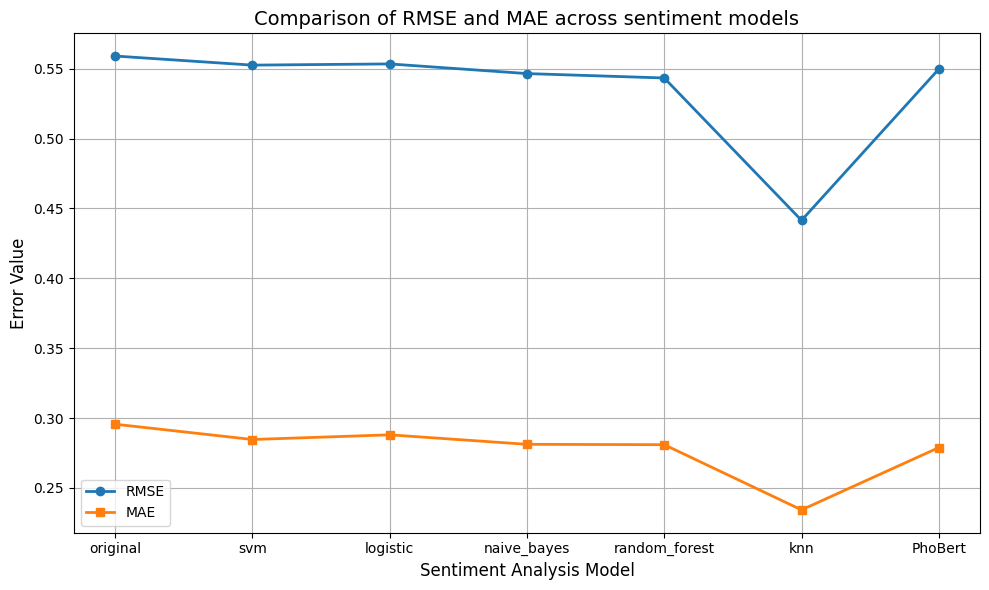

In [10]:
# Extract model names and their corresponding RMSE and MAE values
from matplotlib import pyplot as plt


models = list(mf_results.keys())
rmse_scores = [mf_results[m][0] for m in models]
mae_scores = [mf_results[m][1] for m in models]

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(models, rmse_scores, marker="o", label="RMSE", linewidth=2)
plt.plot(models, mae_scores, marker="s", label="MAE", linewidth=2)

# Customize the chart
plt.title("Comparison of RMSE and MAE across sentiment models", fontsize=14)
plt.xlabel("Sentiment Analysis Model", fontsize=12)
plt.ylabel("Error Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the chart
plt.show()